In [2]:
import os 
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import json

In [21]:
#sc_out = pd.DataFrame()
#for file in os.listdir('../ce_data/StatCache'):
#    x = pd.read_csv("../ce_data/StatCache/"+file)
#    x['id'] = x.index
#    x['id'] = x['id'].apply(lambda x: file[:-4] + "_" + str(x))
#    sc_out = pd.concat([x, sc_out], ignore_index=True)
#sc_out = sc_out.sort_values("id", ascending=True, ignore_index=True).fillna(0)
sc_out = pd.read_csv('../ce_data/output_512/statcache_512.csv')
for i in ['32','64','128','256','512','1024','2048','4096','8192']:
    sc_out['lru_'+i] = sc_out['lru_'+i]/sc_out['total_accesses']
print(sc_out)

                         id  random_32    lru_32  random_64    lru_64  \
0       400.perlbench-41B_0   0.003548  0.002540   0.002449  0.001801   
1     400.perlbench-41B_418   0.017888  0.012395   0.011786  0.008318   
2     400.perlbench-41B_535   0.017095  0.012190   0.011420  0.008070   
3       400.perlbench-50B_0   0.003792  0.002388   0.002205  0.001442   
4     400.perlbench-50B_493   0.009406  0.006427   0.006294  0.004476   
...                     ...        ...       ...        ...       ...   
7291       657.xz_s-4994B_0   0.008308  0.005719   0.005012  0.003447   
7292     657.xz_s-4994B_174   0.010016  0.007303   0.006782  0.004965   
7293     657.xz_s-4994B_362   0.009772  0.006924   0.006416  0.004663   
7294     657.xz_s-4994B_563   0.009711  0.006295   0.006538  0.004888   
7295         657.xz_s-56B_0   0.000000  0.000000   0.000000  0.000000   

      random_128   lru_128  random_256   lru_256  random_512   lru_512  \
0       0.001900  0.001545    0.001656  0.001381 

In [22]:
cache_misses = pd.read_csv("../ce_data/output_512/dataset.csv")
for i in ['1024', '2048', '4096', '8192']:
    cache_misses[i] =  cache_misses['misses_'+i] / cache_misses['accesses_'+i]
cache_misses = cache_misses[sc_out['total_accesses'] > 0]
sc_out = sc_out[sc_out['total_accesses'] > 0]
print(cache_misses, sc_out)

                         id         0         1         2        3        4  \
0       400.perlbench-41B_0  48486896  16534944  11269872  7347024  3587856   
1     400.perlbench-41B_418  15126048   5219040   3717200  2277376  1575632   
2     400.perlbench-41B_535  15353376   5205904   3685936  2272784  1578496   
3       400.perlbench-50B_0  55123232  16123168  13797616  8962624  6739840   
4     400.perlbench-50B_493  24602736   7493280   6130544  4009984  3216688   
...                     ...       ...       ...       ...      ...      ...   
7291       657.xz_s-4994B_0   9235744   9865600   4683024  3626736  4171776   
7292     657.xz_s-4994B_174   9843216  10445696   5134928  3935216  4373984   
7293     657.xz_s-4994B_362  10674864  11244112   5502048  4232272  4618096   
7294     657.xz_s-4994B_563   8198672   8811632   4190272  3216352  3894096   
7295         657.xz_s-56B_0  26404208  36893024  10084752  2060848  2511312   

            5        6        7        8  ...  acce

In [23]:
# Little check
d = {}
for i,j in zip(cache_misses["id"], sc_out["id"]):
    if i != j:
        print(i)
    if i in d: 
        print(i)
    d[i]=1

In [24]:
from sklearn.metrics import mean_squared_error
bdf = pd.DataFrame()
for i in ['1024', '2048', '4096', '8192']:
    tmp = sc_out['lru_'+i] / sc_out['lru_512']
    # This drops na
    cms = cache_misses[tmp <= 1]
    tmp = tmp[tmp <= 1]
    c_acc_lru = mean_squared_error(tmp, cms[i])
    #c_acc_rand = mean_squared_error(o['random_'+i], cache_misses[i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}')
    bdf['sc_'+i] = tmp
    bdf['cm_'+i] = cms[i]
    bdf['diffs_'+i] = abs(tmp - cms[i])

Cache size 1024	: lru_mse = 0.08430919565204864
Cache size 2048	: lru_mse = 0.10691087846991122
Cache size 4096	: lru_mse = 0.10579507744422367
Cache size 8192	: lru_mse = 0.0903183406618082


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in ['1024','2048','4096','8192']:
    tmp = sc_out['lru_'+i] * cache_misses['l1d_accesses_'+i]/cache_misses['accesses_'+i]
    c_acc_lru = mean_squared_error(sc_out['lru_'+i], cache_misses[i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}')

Cache size 1024	: lru_mse = 0.36850779133575845
Cache size 2048	: lru_mse = 0.3263504596548661
Cache size 4096	: lru_mse = 0.25795501366698065
Cache size 8192	: lru_mse = 0.1988591557932595


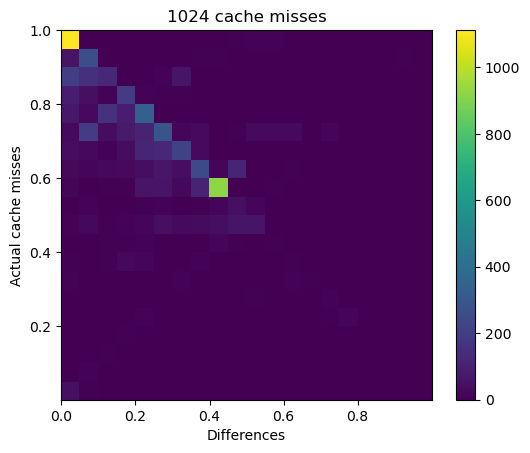

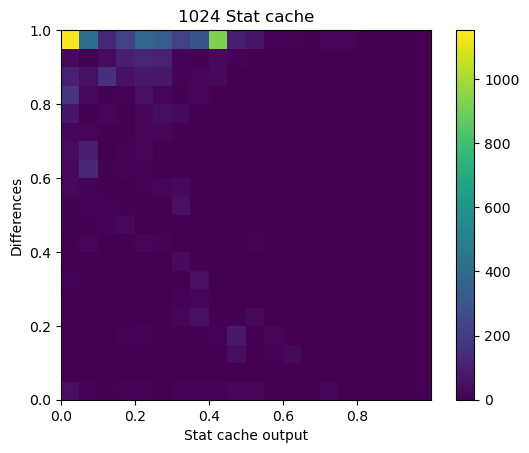

In [42]:
heatmap, xedges, yedges = np.histogram2d(bdf['diffs_1024'], bdf['cm_1024'], bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.title('1024 cache misses')
plt.xlabel('Differences')
plt.ylabel('Actual cache misses')
plt.show()
heatmap, xedges, yedges = np.histogram2d(bdf['diffs_1024'],  bdf['sc_1024'], bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.title('1024 Stat cache')
plt.xlabel('Stat cache output')
plt.ylabel('Differences')
plt.show()

In [ ]:
for i in ['1024','2048','4096','8192']:
    plt.title(i + ' cache misses')
    plt.ylabel('Actual cache misses')
    plt.xlabel('Differences')
    plt.scatter(bdf['diffs_'+i], bdf['cm_'+i], marker='x', linewidths = 0.5)
    plt.show()
    plt.title(i + ' Stat cache')
    plt.ylabel('Stat cache output')
    plt.xlabel('Differences')
    plt.scatter(bdf['diffs_'+i], bdf['sc_'+i], marker='x', linewidths = 0.5)
    plt.show()

In [ ]:
for i in ['1024','2048','4096','8192']:
    plt.title(f"Difference histogram of size {i}")
    plt.hist(bdf['diffs_'+i], bins =30)
    plt.show()

In [ ]:
for i in ['1024','2048','4096','8192']:
    c_acc_lru = mean_squared_error(np.random.random(size=len(cache_misses)), cache_misses[i])
    c_mae_lru = mean_absolute_error(np.random.random(size=len(cache_misses)), cache_misses[i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}, lru_mae = {c_mae_lru}')

In [ ]:
for i in ['1024','2048','4096','8192']:
    c_acc_lru = mean_squared_error([0.5]*len(cache_misses), cache_misses[i])
    c_mae_lru = mean_absolute_error([0.5]*len(cache_misses), cache_misses[i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}, lru_mae = {c_mae_lru}')

In [ ]:
for i in ['1024','2048','4096','8192']:
    c_acc_lru = mean_squared_error(bdf[bdf['sc_'+i] < 0.6]['sc_'+i], bdf[bdf['sc_'+i] < 0.6]['cm_'+i])
    c_mae_lru = mean_absolute_error(bdf[bdf['sc_'+i] < 0.6]['sc_'+i], bdf[bdf['sc_'+i] < 0.6]['cm_'+i])
    print(f'Cache size {i}\t: lru_mse = {c_acc_lru}, lru_mae = {c_mae_lru}')

In [ ]:
plt.scatter(bdf['cm_1024'], bdf['diffs_1024'], marker='x', linewidths = 0.3)
plt.show()
plt.scatter(bdf['sc_1024'], bdf['diffs_1024'], marker='x', linewidths = 0.3)
plt.show()